# 03_modeling.ipynb

## 1. Objective
The purpose of this notebook is to train and evaluate an **XGBoost classifier** that predicts whether a customer will place a repeat order within **180 days** of their first delivered purchase. The goal is not to produce a high-performance production model, but to demonstrate a full end-to-end modeling workflow, including:

- Preparing a modeling dataset derived from Olist’s transactional tables  
- Handling a highly imbalanced target (positive rate ~2.7%)  
- Training an XGBoost classifier and evaluating its performance  
- Generating a lift table and lift chart to understand how predictive power is concentrated across probability deciles  

While the model’s predictive strength is limited, the resulting analysis provides a structured way to explore repeat-order behavior and lays the groundwork for more advanced feature engineering or alternative modeling approaches.

**Target variable:** `reordered_180d`  
**Problem type:** Binary classification

## 2. Import Libraries

In [33]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# Model
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Load the Modeling Data

In [34]:
df_model = pd.read_csv("../data/processed/df_model.csv")
df_model.head()

,reordered_180d,days_to_deliver,actual_vs_estimated_delivery_days,first_order_item_count,first_order_price,freight_price_ratio,first_order_review_score,review_comment_flag,review_comment_length,review_response_delay_days,...,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,first_order_month,first_order_weekday,was_late_flag
0,0,25.731760,-1.389734,1,69.00,0.249565,3,0,0,1.055370,...,0,0,0,1,0,0,0,3,4,0
1,0,20.037083,-11.108970,1,25.99,0.678338,4,1,12,1.012396,...,0,0,0,0,0,0,0,10,3,0
2,0,13.141134,-7.035463,1,180.00,0.093833,5,0,0,4.937211,...,0,0,0,0,0,1,0,11,1,0
3,0,4.375648,-27.643658,1,135.00,0.112000,4,0,0,6.156933,...,0,0,0,0,0,0,0,3,5,0
4,0,16.388645,-11.220266,1,13.90,1.086331,3,1,47,4.994595,...,0,0,0,0,0,0,0,7,1,0


## 4. Model Setup and Training

### 4.1 Define Features and Target
We separate the feature matrix and target variable for model training.

In [35]:
target = "reordered_180d"

# Use all remaining columns as features
features = [col for col in df_model.columns if col != target]

X = df_model[features]
y = df_model[target]

### 4.2 Train-Test Split
We create an 80/20 split while preserving class proportions by using stratification.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### 4.3 XGBoost Setup: Class Imbalance and Hyperparameter Search
To address the strong class imbalance in the target (positive rate ~2.7%), we compute a 
`scale_pos_weight` ratio and pass it to XGBoost. We then define a parameter search space 
and run a randomized hyperparameter search with stratified cross-validation optimized for ROC-AUC.

In [37]:
# Calculate imbalance ratio for XGBoost's scale_pos_weight parameter
neg = (y == 0).sum()
pos = (y == 1).sum()
neg_to_pos = neg / pos

# Base XGBoost model with imbalance handling
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=neg_to_pos,
    n_estimators=800,
    n_jobs=-1,
    random_state=42,
    tree_method='hist'  # if available
)

# Hyperparameter search space
param_dist = {
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.5, 1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.01, 0.03, 0.05, 0.1]
}

# Stratified cross-validation to preserve class distribution
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized search over hyperparameters, optimized for ROC-AUC
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

# Select best model
best_xgb = search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


### 4.4 Train the XGBoost Model

In [38]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=-1, num_parallel_tree=None, ...)

## 5. Evaluate Performance
We evaluate the model on the test set using multiple metrics suited for imbalanced classification:
- **Classification report** for precision, recall, and F1
- **Confusion matrix** to understand prediction distribution
- **ROC-AUC score** as the primary performance metric
- **Distribution of predicted probabilities** to visualize model confidence

### 5.1 Classification Metrics

In [39]:
# Predictions on the test set
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Performance metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78     10200
           1       0.04      0.52      0.07       289

    accuracy                           0.64     10489
   macro avg       0.51      0.58      0.43     10489
weighted avg       0.95      0.64      0.76     10489

[[6602 3598]
 [ 138  151]]
ROC-AUC: 0.6091748083316371


### 5.2 Probability Diagnostics

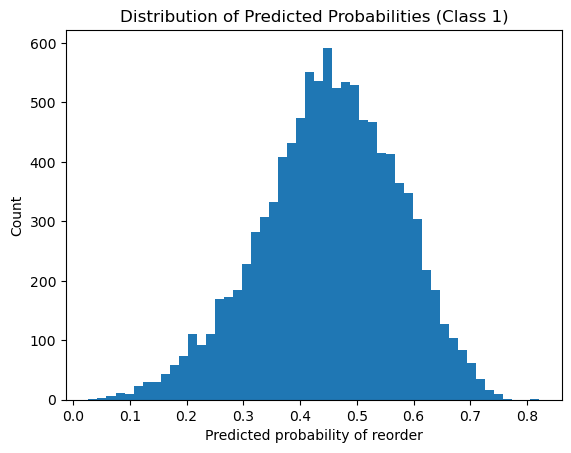

In [40]:
# Distribution of predicted probabilities for the positive class (model confidence is weak)
plt.hist(y_proba, bins=50)
plt.title("Distribution of Predicted Probabilities (Class 1)")
plt.xlabel("Predicted probability of reorder")
plt.ylabel("Count")
plt.show()

In [41]:
# Quick sanity checks on predicted probabilities
print(y_proba.mean())
print(y_proba.max())

0.45149556
0.8216206


We also evaluate model performance across multiple probability thresholds to 
understand how the precision–recall tradeoff behaves under severe class imbalance.

### 5.3 Threshold Sensitivty 

In [42]:
# Helper function to evaluate model performance at different probability thresholds
def evaluate_threshold(threshold):
    y_pred_thresh = (y_proba >= threshold).astype(int)
    print(f"=== Threshold: {threshold} ===")
    print(confusion_matrix(y_test, y_pred_thresh))
    print(classification_report(y_test, y_pred_thresh))
    print()

# Test through a range of thresholds
for t in [0.5, 0.3, 0.2, 0.15, 0.1, 0.07, 0.05]:
    evaluate_threshold(t)

=== Threshold: 0.5 ===
[[6602 3598]
 [ 138  151]]
              precision    recall  f1-score   support

           0       0.98      0.65      0.78     10200
           1       0.04      0.52      0.07       289

    accuracy                           0.64     10489
   macro avg       0.51      0.58      0.43     10489
weighted avg       0.95      0.64      0.76     10489


=== Threshold: 0.3 ===
[[1158 9042]
 [  16  273]]
              precision    recall  f1-score   support

           0       0.99      0.11      0.20     10200
           1       0.03      0.94      0.06       289

    accuracy                           0.14     10489
   macro avg       0.51      0.53      0.13     10489
weighted avg       0.96      0.14      0.20     10489


=== Threshold: 0.2 ===
[[ 278 9922]
 [   6  283]]
              precision    recall  f1-score   support

           0       0.98      0.03      0.05     10200
           1       0.03      0.98      0.05       289

    accuracy                  

### 5.4 ROC Curve

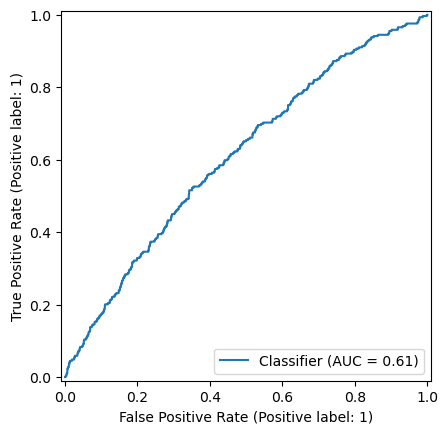

In [43]:
# Plot ROC curve using test labels and predicted probabilities
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

## 6. Feature Importance
We examine the top features used by the XGBoost model based on its built-in feature importance 
scores. These values reflect how often and how effectively each feature is used to split nodes 
in the trees (using the “gain” metric by default).

Because the model has limited predictive power, these importances should be interpreted as 
exploratory indicators rather than definitive drivers of reorder behavior.

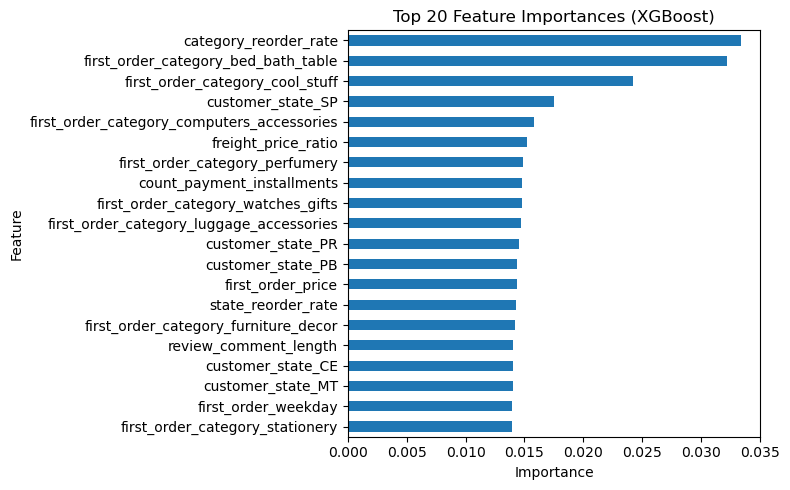

In [44]:
# Compute feature importances and sort from highest to lowest
importances = pd.Series(
    best_xgb.feature_importances_,
    index=features
).sort_values(ascending=False)

# Select top N features for visualization
top_n = 20
top_importances = importances.head(top_n).sort_values()

# Plot top feature importances
plt.figure(figsize=(8, 5))
top_importances.plot(kind="barh")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The model relies heavily on product-category-level reorder rates and customer location 
encodings, while delivery-related features have comparatively lower influence.

In [45]:
importances.head(50)

category_reorder_rate                                   0.033341
first_order_category_bed_bath_table                     0.032226
first_order_category_cool_stuff                         0.024181
customer_state_SP                                       0.017482
first_order_category_computers_accessories              0.015834
freight_price_ratio                                     0.015254
first_order_category_perfumery                          0.014912
count_payment_installments                              0.014831
first_order_category_watches_gifts                      0.014829
first_order_category_luggage_accessories                0.014720
customer_state_PR                                       0.014495
customer_state_PB                                       0.014390
first_order_price                                       0.014374
state_reorder_rate                                      0.014312
first_order_category_furniture_decor                    0.014220
review_comment_length    

## 7. Lift Analysis

### 7.1 Create Individual Reorder Probabilities Table
We combine the true labels and predicted probabilities for the test set, sort customers by 
predicted likelihood of reorder, and assign each customer to a decile group. These deciles 
form the foundation of the lift analysis performed in later steps.

Note that deciles are based on ranked probability rather than probability value. This ensures 
each decile contains approximately the same number of customers, making lift comparison 
more interpretable across groups.

The resulting table is exported for use in external analysis.

In [46]:
# Combine true labels and predicted probabilities
df_scores = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_proba
})

# Sort customers by predicted probability (highest to lowest)
df_scores = df_scores.sort_values('y_proba', ascending=False).reset_index(drop=True)

# Export individual-level scores for external analysis
df_scores.to_csv('../data/processed/first_order_customer_reorder_scores.csv', index=False)

# Assign deciles based on sorted rank (1 = highest probability)
df_scores['decile'] = pd.qcut(df_scores.index, 10, labels=False) + 1

df_scores.head()

,y_true,y_proba,decile
0,0,0.821621,1
1,0,0.765494,1
2,0,0.763660,1
3,0,0.756776,1
4,0,0.754750,1


### 7.2 Create Lift Table
We aggregate customers into deciles (from Section 7.1) and compute key metrics needed to 
evaluate lift:

- **customers**: number of observations in each decile  
- **actual_positives**: number of true reorders  
- **actual_positive_rate**: reorder rate for the decile  
- **avg_predicted_probability**: average model score  
- **lift**: how much better the decile performs compared to the overall baseline rate  

The lift table is then exported for further analysis or visualization.

In [47]:
# Aggregate metrics by decile for lift analysis
lift_table = df_scores.groupby('decile').agg(
    customers=('y_true', 'count'),
    actual_positives=('y_true', 'sum'),
    avg_predicted_probability=('y_proba', 'mean')
).reset_index()

# Compute actual positive rate per decile
lift_table['actual_positive_rate'] = lift_table['actual_positives'] / lift_table['customers']

# Baseline reorder rate across the entire test set (used to compute lift)
baseline_rate = df_scores['y_true'].mean()

# Lift = decile's reorder rate relative to the baseline
lift_table['lift'] = lift_table['actual_positive_rate'] / baseline_rate

# Sort deciles in ascending order for clean presentation and export
lift_table = lift_table.sort_values('decile')
lift_table.to_csv('../data/processed/lift_table.csv', index=False)

lift_table

,decile,customers,actual_positives,avg_predicted_probability,actual_positive_rate,lift
0,1,1049,49,0.647403,0.046711,1.695340
1,2,1049,44,0.579950,0.041945,1.522346
2,3,1049,37,0.538418,0.035272,1.280155
3,4,1049,31,0.502862,0.029552,1.072562
4,5,1049,27,0.470957,0.025739,0.934167
5,6,1048,21,0.441112,0.020038,0.727268
6,7,1049,28,0.410287,0.026692,0.968766
7,8,1049,24,0.374147,0.022879,0.830371
8,9,1049,15,0.324520,0.014299,0.518982
9,10,1049,13,0.225289,0.012393,0.449784


### 7.3 Create Lift Chart
The lift chart visualizes how well the model separates high-probability customers from the 
rest of the population. Each point represents a decile (1 = highest predicted probability), 
and the y-axis shows how much higher or lower that decile's actual reorder rate is compared 
to the overall baseline rate (lift = 1.0).

A lift greater than 1 indicates that the model is identifying customers who reorder at a 
higher rate than average; a lift below 1 indicates performance worse than random selection.

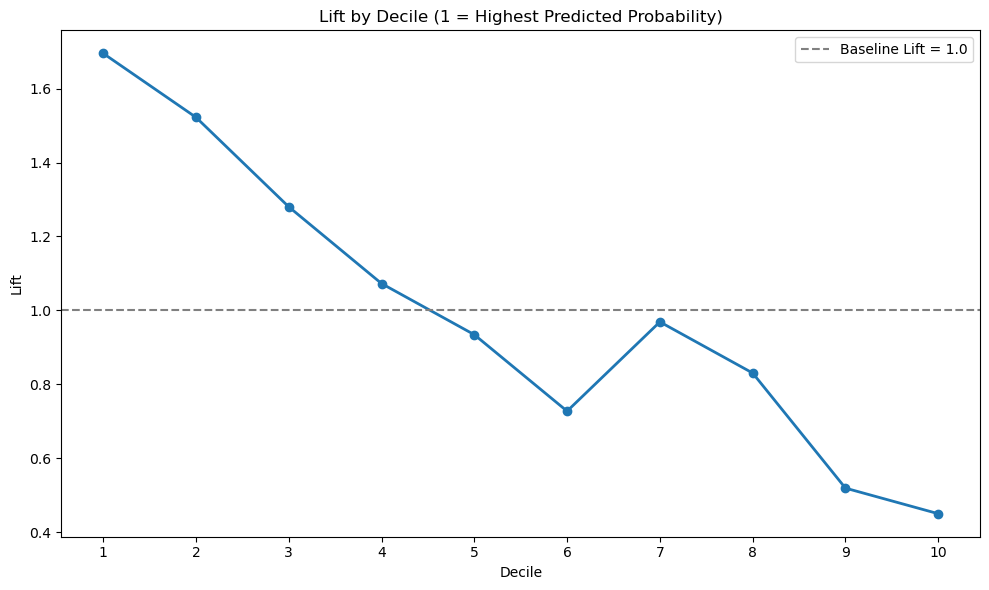

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lift values by decile (1 = highest predicted probability)
ax.plot(
    lift_table['decile'],
    lift_table['lift'],
    marker='o',
    linewidth=2
)


# Add a baseline reference line at lift = 1.0
ax.axhline(1.0, color='gray', linestyle='--', label='Baseline Lift = 1.0')

# Chart title and axis labels
ax.set_title('Lift by Decile (1 = Highest Predicted Probability)')
ax.set_xlabel('Decile')
ax.set_ylabel('Lift')

# Set decile tick marks from 1 to 10
ax.set_xticks(range(1, 11))

plt.legend()
plt.tight_layout()


# Save figure for reporting
fig.savefig(
    '../assets/figures/lift_chart.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

The lift curve shows modest separation between higher and lower probability groups. The 
top deciles (1–3) demonstrate lift above 1.0, indicating that the model does add some value 
in identifying customers with higher reorder likelihood. However, the drop in lift after 
the top deciles reflects the model's limited discriminative power, consistent with the ROC-AUC 
score of ~0.61.

This level of performance can still be useful for exploratory analysis or as a baseline 
model, but would require additional feature engineering or enriched data to achieve 
stronger business impact.

## 8. Conclusion

The model shows modest but meaningful ability to identify first-order customers who are more likely to reorder within 180 days. The top three deciles outperform the overall baseline reorder rate, indicating that targeted retention efforts focused on these segments would be more efficient than random outreach. However, the separation between segments remains limited, so this model should be viewed as a baseline version rather than a production-ready solution. Expanding the feature set particularly around customer behavior and product context would be the most direct path to improving predictive power and increasing potential business impact.